In [ ]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict,Annotated
from dotenv import load_dotenv
import os
from pydantic import BaseModel, Field
import operator
from typing import Literal

In [ ]:
Api_key = os.getenv("OPENAI_API_KEY")
model = ChatOpenAI(
    model="openai/gpt-4o-mini",
    base_url="https://openrouter.ai/api/v1",
    api_key= Api_key
)

In [ ]:
class SentimentSchema(BaseModel):
    sentiment: Literal["positive", "negative"] = Field(
        description="The sentiment of the given text."
    )



In [ ]:
class DiagonesisSchema(BaseModel):
    issue_type :Literal["bug", "feature_request", "other"] =Field(description="The type of issue described in the review.")
    tone :Literal["angry", "happy", "neutral"] = Field(description="The tone of the review.")
    urgency :Literal["low", "medium", "high"] = Field(description="The urgency level of the issue described in the review.")

In [ ]:
structured_model = model.with_structured_output(SentimentSchema)
diagonesis_model = model.with_structured_output(DiagonesisSchema)

In [ ]:
text = "Its good but could be better. but i love it"

In [ ]:
prompt = f"What is the sentiment of the following text? Respond with 'positive' or 'negative' only.\n\nText: {{text}}"

In [ ]:
response = structured_model.invoke(prompt)
response

SentimentSchema(sentiment='positive')

In [ ]:
response.sentiment

'positive'

In [ ]:
class Reviewstate(TypedDict):
    review : str
    sentiment: Literal["positive", "negative"]
    diagonesis : dict
    response : str



In [ ]:
def find_sentiment(state: Reviewstate)  -> dict:
    prompt = f"What is the sentiment of the following text? Respond with 'positive' or 'negative' only.\n\nText: {state['review']}"
    response = structured_model.invoke(prompt)
    sentiment = response.sentiment
    return {
        "sentiment" : sentiment
    }


def check_sentiment(state: Reviewstate) -> Literal["positive_response", "run_diagonesis"]:
    if state["sentiment"] == "positive":
        return "positive_response"
    else: 
        return "run_diagonesis"
    

def positive_response(state: Reviewstate):
    prompt = f"write a a thank you for the positive response \n \n {state['review']} \n \n also ask if they need any further assistance and also offer them a discount code for their next purchase"
    response = model.invoke(prompt).content
    return {
        "response": response
    }
def run_diagonesis(state: Reviewstate):
    prompt = f"""
    Diagonose this negative review  : \n \n {state['review']} \n \n
    return issue_type, tone and urgency."""
    response = diagonesis_model.invoke(prompt)
    return {
        "diagonesis" : response.model_dump()  # Convert Pydantic model to dictionary
    }


def negative_response(state: Reviewstate):
    prompt = f"""
    You are a support assistent with 20 years of experience call youself James , add a suitable position. The user had a {state['diagonesis']['issue_type']} , sounded {
    state['diagonesis']['tone']} and the urgency level is {state['diagonesis']['urgency']}.
    write a response to the following review apologizing for the inconvenience and assuring them that their issue will be resolved promptly. Also offer them a discount code for their next purchase. \n \n {state['review']}
    ."""
    response = model.invoke(prompt).content
    return {
        "response": response
    }

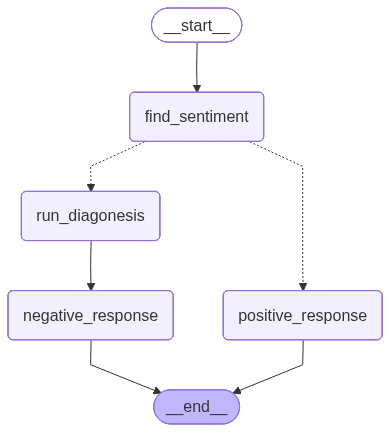

In [ ]:
graph = StateGraph(Reviewstate)

graph.add_node("find_sentiment",find_sentiment)
graph.add_node("positive_response",positive_response)
graph.add_node("negative_response",negative_response)
graph.add_node("run_diagonesis",run_diagonesis)

graph.add_edge(START,"find_sentiment")
graph.add_conditional_edges("find_sentiment",check_sentiment)
graph.add_edge("positive_response",END)
graph.add_edge("run_diagonesis","negative_response")    
graph.add_edge("negative_response",END)

workflow = graph.compile()
workflow

In [ ]:
initial_state = {
    "review" : f"""I recently visited a highly-rated local restaurant that left me extremely dissatisfied. The service was slow and unprofessional from the start; we waited over 20 minutes just to place our order. When the food finally arrived, my order was incorrect, cold, and entirely unappetizing. The overall cleanliness of the establishment was also a major concern, with sticky tables and an unpleasant odor.
                Despite bringing these significant issues to the attention of the staff, no genuine effort was made to rectify the situation or offer a solution. The management's lack of response was as disappointing as the meal itself. Based on this experience, I would not recommend this restaurant to anyone. Save your money and go elsewhere for a better dining experience."""}

final_state = workflow.invoke(initial_state)
final_state

{'review': "I recently visited a highly-rated local restaurant that left me extremely dissatisfied. The service was slow and unprofessional from the start; we waited over 20 minutes just to place our order. When the food finally arrived, my order was incorrect, cold, and entirely unappetizing. The overall cleanliness of the establishment was also a major concern, with sticky tables and an unpleasant odor.\n                Despite bringing these significant issues to the attention of the staff, no genuine effort was made to rectify the situation or offer a solution. The management's lack of response was as disappointing as the meal itself. Based on this experience, I would not recommend this restaurant to anyone. Save your money and go elsewhere for a better dining experience.",
 'sentiment': 'negative',
 'diagonesis': {'issue_type': 'bug', 'tone': 'angry', 'urgency': 'high'},
 'response': "Subject: Our Sincere Apologies and a Way to Make It Right\n\nDear [Reviewer's Name],\n\nMy name i